/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training fold 1...
Epoch 1 | Train Loss: 0.9796 | Validation Loss: 0.9291
Epoch 2 | Train Loss: 0.8662 | Validation Loss: 0.9068
Epoch 3 | Train Loss: 0.7116 | Validation Loss: 1.0041
Epoch 4 | Train Loss: 0.5166 | Validation Loss: 1.0620
Epoch 5 | Train Loss: 0.2560 | Validation Loss: 1.3181

Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       0.49      0.52      0.50       126
           1       0.44      0.50      0.47       101
           2       0.73      0.60      0.66       123

    accuracy                           0.54       350
   macro avg       0.55      0.54      0.54       350
weighted avg       0.56      0.54      0.55       350


Training fold 2...
Epoch 1 | Train Loss: 0.4850 | Validation Loss: 0.1980
Epoch 2 | Train Loss: 0.1365 | Validation Loss: 0.1886
Epoch 3 | Train Loss: 0.0913 | Validation Loss: 0.2253
Epoch 4 | Train Loss: 0.0472 | Validation Loss: 0.2059
Epoch 5 | Train Loss: 0.0393 | Validation Loss: 0

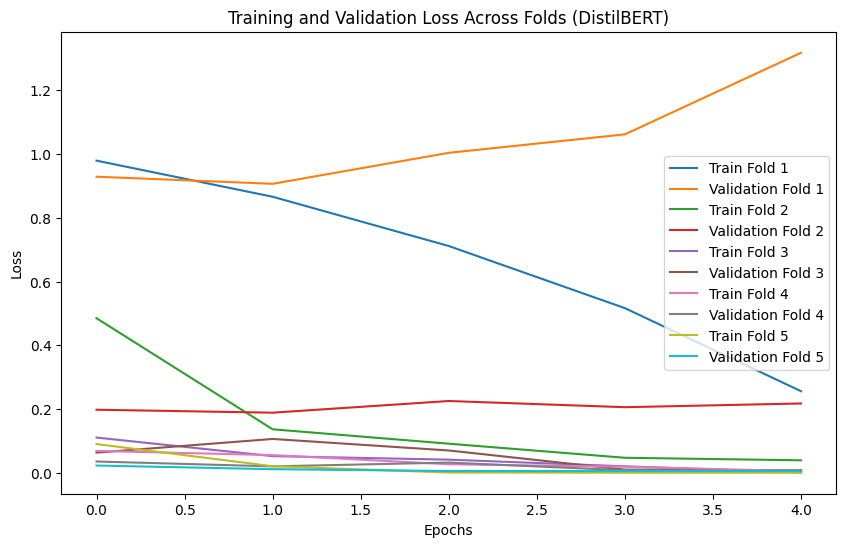

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

# Load dataset
df = pd.read_csv('combined_processed_tweets_basic_cleaning.csv')

# Clean the 'processed_text' column
df['processed_text'] = df['processed_text'].fillna('').astype(str)

# Reset index to avoid potential issues with misaligned indices after split
df.reset_index(drop=True, inplace=True)

# Split the dataset into features and labels
texts = df['processed_text']
labels = df['encoded_label']

# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Function to train and evaluate the model
def train_and_evaluate(train_texts, train_labels, val_texts, val_labels, model, optimizer, scheduler, device, class_weights):
    # Tokenize the train and validation set
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256)
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=256)

    # Create dataset
    train_dataset = SentimentDataset(train_encodings, train_labels)
    val_dataset = SentimentDataset(val_encodings, val_labels)

    # DataLoader for training and validation
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Define loss function with class weights
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    # Initialize lists to track loss values
    train_losses = []
    val_losses = []

    # Training loop
    model.train()
    for epoch in range(5):  # Train for 5 epochs
        total_train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch['labels'])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = loss_fn(outputs.logits, batch['labels'])
                total_val_loss += loss.item()

        # Step the scheduler
        scheduler.step()

        # Calculate average loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        # Track the losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

    # Collect predictions for classification report
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    return train_losses, val_losses, all_preds, all_labels

# Hyperparameter Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model.to(device)

# AdamW optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to track best model
best_model = None
best_tokenizer = None
best_val_loss = float('inf')

# Track losses for plotting
all_train_losses = []
all_val_losses = []

# Class weights (for handling class imbalance)
class_weights = torch.tensor([1.0, 2.0, 1.5]).to(device)  # Example weights for 3 classes

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\nTraining fold {fold+1}...")

    # Split data into train and validation sets for the current fold
    train_texts, val_texts = texts.iloc[train_idx], texts.iloc[val_idx]
    train_labels, val_labels = labels.iloc[train_idx], labels.iloc[val_idx]

    # Reset indices
    train_texts = train_texts.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    # Learning rate scheduler
    total_steps = len(train_texts) * 5  # 5 epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Train and evaluate
    train_losses, val_losses, val_preds, val_true = train_and_evaluate(
        train_texts, train_labels, val_texts, val_labels, model, optimizer, scheduler, device, class_weights
    )

    # Print classification report for this fold
    print(f"\nClassification Report for Fold {fold+1}:")
    print(classification_report(val_true, val_preds))

    # Store losses for this fold
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # Check if the validation loss improved, and save the model if it did
    final_val_loss = val_losses[-1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model
        best_tokenizer = tokenizer

# Save the best model after all folds
final_model_save_path = '/content/my_final_trained_model_distilbert'

# Create directory to save model if it doesn't exist
if not os.path.exists(final_model_save_path):
    os.makedirs(final_model_save_path)

# Save the best model and tokenizer
best_model.save_pretrained(final_model_save_path)
best_tokenizer.save_pretrained(final_model_save_path)

print(f"Final best model and tokenizer saved at {final_model_save_path}")

# Plot training and validation loss for each fold
plt.figure(figsize=(10, 6))

# Plot losses for all folds
for i in range(5):
    plt.plot(all_train_losses[i], label=f'Train Fold {i+1}')
    plt.plot(all_val_losses[i], label=f'Validation Fold {i+1}')

plt.title('Training and Validation Loss Across Folds (DistilBERT)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [3]:
import os
import shutil
from google.colab import files

# Check if the model folder exists
model_dir = '/content/my_final_trained_model_distilbert'

# Ensure that the model directory exists before proceeding
if os.path.exists(model_dir):
    # Zip the model folder
    model_zip_path = model_dir + '.zip'
    shutil.make_archive(model_zip_path.replace('.zip', ''), 'zip', model_dir)

    # Trigger file download
    files.download(model_zip_path)
    print(f"Model saved and available for download at: {model_zip_path}")
else:
    print("Model directory not found. Please ensure the model is saved first.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved and available for download at: /content/my_final_trained_model_distilbert.zip
